In [15]:
import h5py
import pathlib
from tqdm import tqdm

import ipywidgets as widgets
import matplotlib.pyplot as plt
import nrrd
import numpy as np
import skimage.transform as st
from numpy import ma
from sklearn.metrics import normalized_mutual_info_score

from atlalign.visualization import create_segmentation_image
from atlannot.evaluation import entropy
from atlannot.utils import edge_sobel, edge_laplacian_thin

### Data

To experiment with Nissl from Allen Brain (modified): https://zenodo.org/record/4486659#.YvugLGFBzmF

In [19]:
nissl_path = pathlib.Path("/raid/users/edelattr/deal/annotation/data/ara_nissl_25.nrrd")
ccfv2_path = pathlib.Path("/raid/users/edelattr/deal/annotation/data/annotation_25_2011_full.nrrd")

Load Nissl and compute minimum and maximum intensity 

In [74]:
nissl, nissl_header = nrrd.read(nissl_path)
nissl_min = nissl.min()
nissl_max = nissl.max()

In [16]:
volumes = h5py.File("/raid/users/edelattr/deal/ccf2017-mod65000-border-centered-mm-bc.h5", "r")
nissl_10 = volumes['t00000']['s00']['0']['cells']
nissl_10 = np.transpose(nissl_10, (2, 1, 0))
nissl = st.resize(nissl_10, (528, 320, 456))

In [75]:
nissl.shape

(528, 320, 456)

Load corresponding annotation volume (ccfv2)

In [76]:
ccfv2, _ = nrrd.read(ccfv2_path)

### Utils

In [77]:
_, color_map = create_segmentation_image(np.unique(ccfv2))

In [78]:
def volumes_visualization(volumes, is_atlas, titles=None):
    @widgets.interact(
        axis = widgets.Dropdown(
            options=[('Coronal', 0), ('Transverse', 1), ('Sagittal', 2)],
            value=1,
            description='Axis:',
            disabled=False,),
    )
    def results_vis(axis):

        volumes_tmp = [np.moveaxis(v, axis, 0) for v in volumes]

        @widgets.interact(
        slide = widgets.IntSlider(
            min=0,
            max=volumes_tmp[0].shape[0],
            description='Section:',
            disabled=False,),
        )
        def results_vis1(slide):
            fig, ax = plt.subplots(1, len(volumes_tmp), figsize=(25, 20))
            if len(volumes_tmp) == 1:
                if titles is not None:
                    ax.set_title(titles[0])
                ax.axes.get_xaxis().set_ticks([])
                ax.axes.get_yaxis().set_ticks([]) 
                if is_atlas[0] == True:
                    ax.imshow(create_segmentation_image(volumes_tmp[0][slide].astype(np.int), color_map)[0])
                else:
                    ax.imshow(volumes_tmp[0][slide])
                
            else:
                for i, (vol, is_atl) in enumerate(zip(volumes_tmp, is_atlas)):
                    ax[i].axes.get_xaxis().set_ticks([])
                    ax[i].axes.get_yaxis().set_ticks([])
                    if titles is not None:
                        ax[i].set_title(titles[i])
                    if is_atl == True:
                        ax[i].imshow(create_segmentation_image(vol[slide].astype(np.int), color_map)[0])
                    else:
                        ax[i].imshow(vol[slide])

In [79]:
def conditional_entropy(
    nissl: np.ndarray,
    atlas: np.ndarray,
    value_range,
) -> float:
    weighted_entropies = []
    n_voxels = 0
    for label, count in zip(*np.unique(atlas, return_counts=True)):
        if label == 0:  # skip background
            continue
        n_voxels += count
        nissl_region = ma.masked_where(atlas != label, nissl)
        entropy_score = entropy(nissl_region, value_range=value_range)
        weighted_entropies.append(entropy_score * count)

    return np.sum(weighted_entropies) / n_voxels

### Checks

Is CCFv2 symmetric?

In [80]:
ccfv2_left = ccfv2[:, :, :228]
ccfv2_right = ccfv2[:, :, 228:]

In [81]:
ccfv2_right_flip = np.flip(ccfv2_right, axis=2)

In [82]:
np.all(ccfv2_left == ccfv2_right_flip)

True

Is Nissl symmetric?

In [83]:
nissl_left = nissl[:, :, :228]
nissl_left_flip = np.flip(nissl_left, axis=2)
nissl_right = nissl[:, :, 228:]
nissl_right_flip = np.flip(nissl_right, axis=2)

In [84]:
symmetric_slice = []
for i, (nissl_left_slice, nissl_right_flip_slice) in enumerate(zip(nissl_left, nissl_right_flip)):
    if np.allclose(nissl_left_slice, nissl_right_flip_slice, rtol=0):
        symmetric_slice.append(i)

In [85]:
len(symmetric_slice)

0

In [86]:
volumes_visualization([np.abs(nissl_left_flip - nissl_right), nissl], [False, False])

interactive(children=(Dropdown(description='Axis:', index=1, options=(('Coronal', 0), ('Transverse', 1), ('Sag…

### Make Nissl Symmetric

Compute which half of every coronal slice **normalized mutual information**

In [87]:
# left_better_nmi = []
# all_conditional_nmi_left = []
# all_conditional_nmi_right = []
# for i, (left_slice, right_slice, left_annot, right_annot) in tqdm(enumerate(zip(nissl_left, nissl_right_flip, ccfv2_left, ccfv2_right_flip))):
#     conditional_nmi_left = normalized_mutual_info_score(left_annot.ravel(), left_slice.ravel())
#     conditional_nmi_right = normalized_mutual_info_score(right_annot.ravel(), right_slice.ravel())
#     all_conditional_nmi_left.append(conditional_nmi_left)
#     all_conditional_nmi_right.append(conditional_nmi_right)
#     if conditional_nmi_left > conditional_nmi_right:
#         left_better_nmi.append(i)

In [88]:
print(left_better_nmi)

[522]


<BarContainer object of 528 artists>

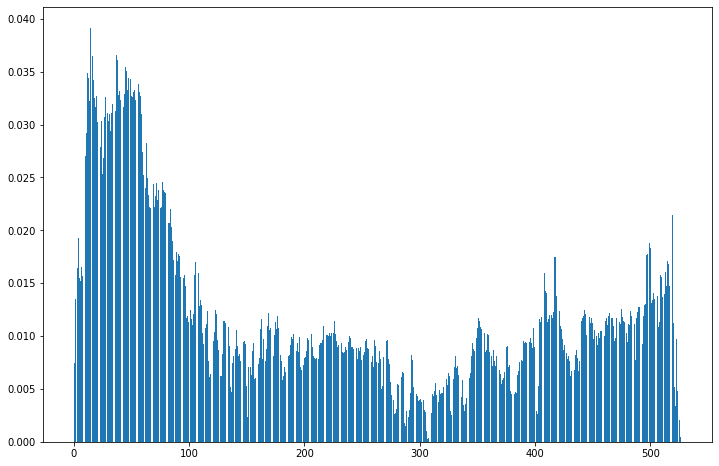

In [89]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(np.arange(0, 528), np.abs(np.array(all_conditional_nmi_left) - np.array(all_conditional_nmi_right)))

Compute which half of every coronal slice **entropy**

In [90]:
left_better = []
entropy_diff = []
for i, (left_slice, right_slice, left_annot, right_annot) in tqdm(enumerate(zip(nissl_left, nissl_right_flip, ccfv2_left, ccfv2_right_flip))):
    conditional_entropy_left = conditional_entropy(left_slice, left_annot, value_range=(nissl_min, nissl_max))
    conditional_entropy_right = conditional_entropy(right_slice, right_annot, value_range=(nissl_min, nissl_max))
    entropy_diff.append(conditional_entropy_left - conditional_entropy_right)
    if conditional_entropy_left < conditional_entropy_right:
        left_better.append(i)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in double_scalars

528it [02:11,  4.02it/s]


In [91]:
print(len(left_better))
print(left_better)

64
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 83, 174, 194, 218, 221, 225, 239, 248, 278, 288, 289, 290, 296, 310, 328, 345, 347, 359, 375, 379, 380, 383, 384, 386, 387, 396, 397, 398, 401, 402, 403, 404, 406, 411, 412, 413, 418, 419, 420, 504, 507, 508, 510, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526]


<BarContainer object of 528 artists>

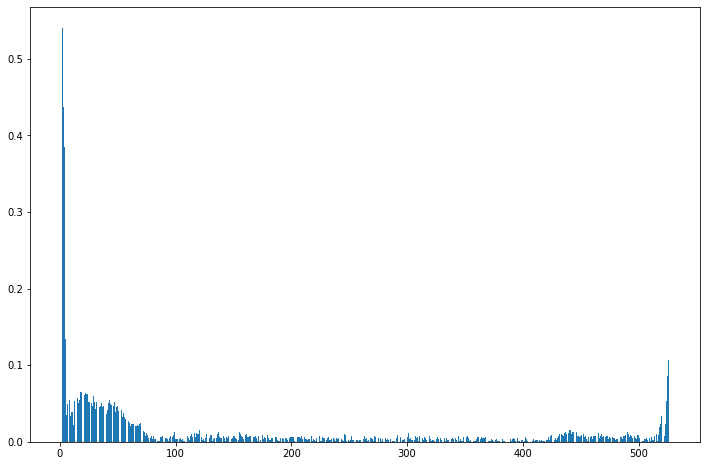

In [92]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(np.arange(0, 528), np.abs(entropy_diff))

In [93]:
boundaries = np.array([edge_laplacian_thin(ccfv2_slice) for ccfv2_slice in ccfv2])

In [94]:
nissl_plus_boundaries = (nissl / nissl_max) + (boundaries / boundaries.max())

In [95]:
def nissl_vis(volumes, titles=None):
    @widgets.interact(
        axis = widgets.Dropdown(
            options=[('Coronal', 0), ('Transverse', 1), ('Sagittal', 2)],
            value=1,
            description='Axis:',
            disabled=False,),
    )
    def results_vis(axis):

        volumes_tmp = [np.moveaxis(v, axis, 0) for v in volumes]

        @widgets.interact(
        slide = widgets.IntSlider(
            min=0,
            max=volumes_tmp[0].shape[0],
            description='Section:',
            disabled=False,),
        )
        def results_vis1(slide):
            fig, ax = plt.subplots(1, len(volumes_tmp), figsize=(25, 20))
            
            if slide in left_better:
                ax.set_title("Left better")
            else:
                ax.set_title("Right better")
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([]) 
            ax.imshow(volumes_tmp[0][slide])

nissl_vis([nissl_plus_boundaries])

interactive(children=(Dropdown(description='Axis:', index=1, options=(('Coronal', 0), ('Transverse', 1), ('Sag…

Reconstruct Nissl by taking the half with the best entropy

In [96]:
new_nissl = np.zeros_like(nissl)
for i in range(528):
    if i in left_better:
        new_nissl[i, :, :228] = nissl_left[i]
        new_nissl[i, :, 228:] = nissl_left_flip[i]
    else:
        new_nissl[i, :, :228] = nissl_right_flip[i]
        new_nissl[i, :, 228:] = nissl_right[i]

In [97]:
nissl_with_middle_line = nissl.copy()
nissl_with_middle_line[:, :, 227:229] = nissl_max

In [98]:
volumes_visualization([(nissl_with_middle_line / nissl_max) + (boundaries / boundaries.max()), nissl, new_nissl], [False, False, False])

interactive(children=(Dropdown(description='Axis:', index=1, options=(('Coronal', 0), ('Transverse', 1), ('Sag…

Results and interpretation
- Normalized mutual information (NMI) seems to be higher for most of the slices (and for the rest, the difference is very small)
- Visually, the annotation ccfv2 seems to be drawn on top of the left hemisphere of the brain (mainly visible at the olfactory bulb and cerebellum area)
- Most of the slices where the entropy is better in the right hemisphere are at the olfactory bulb and the end of the cerebellum (where the quality of the images are not great - presence of holes)
- Entropy difference are higher for the olfactory bulb and the cerebellum because the metric is sensitive to the big variations of intensity

Always take the right side for the entire volume 

In [99]:
new_nissl_right = np.zeros_like(nissl)
for i in range(528):
    new_nissl_right[i, :, :228] = nissl_right_flip[i]
    new_nissl_right[i, :, 228:] = nissl_right[i]

In [100]:
volumes_visualization([nissl_plus_boundaries, nissl, new_nissl_right], [False, False, False])

interactive(children=(Dropdown(description='Axis:', index=1, options=(('Coronal', 0), ('Transverse', 1), ('Sag…

Saving the resulting symmetric nissl volume

In [101]:
nrrd.write("nissl1_symmetric_always_left_hemisphere.nrrd", new_nissl_right, header=nissl_header)
nrrd.write("nissl1_symmetric_best_entropy.nrrd", new_nissl, header=nissl_header)

/usr/local/lib/python3.7/dist-packages/nrrd/writer.py:323: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.7/dist-packages/nrrd/writer.py:323: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



Choosing always the same side keeps the final volume smoother while choosing the best entropy version might introduce misalignment 

(especially visible on transverse axis when the sequence of choice is left - right - left, right introducing the misalignment)

# Comparison between the 2 Nissl volumes

In [103]:
nissl_1, _ = nrrd.read("nissl1_symmetric_always_left_hemisphere.nrrd")
nissl, _ = nrrd.read("nissl_symmetric_always_left_hemisphere.nrrd")

In [ ]:
conditional_entropy(nissl_1, ccfv2, value_range=(nissl_1.min(), nissl_1.max()))

In [ ]:
conditional_entropy(nissl, ccfv2, value_range=(nissl.min(), nissl.max()))